In [1]:
# import nltk
from pyspark.sql import SparkSession
# import pyspark.sql.functions as F
# import pyspark.sql.types as T

from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier,NaiveBayes,LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# from nltk.corpus import stopwords
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import NGram,OneHotEncoder, StringIndexer, VectorAssembler

In [2]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
# from nltk.corpus import stopwords
from pyspark.ml import PipelineModel
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import NGram,OneHotEncoder, StringIndexer, VectorAssembler
from itertools import combinations
from pyspark.sql.functions import *

In [3]:
# !pip install sparknlp

In [4]:

import sparknlp

spark = sparknlp.start()

:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-a5ff9b9f-b70e-4070-b8ff-0ba86133f41f;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.4.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.16.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guava#failureaccess;1.0.1 

In [6]:
df = spark.read.csv("gs://a1_be19b032_bucket/data_final.csv",header=True)

In [7]:
df = df.filter(col('rating')<=5)
df = df.filter(col('rating')>=0)

In [8]:
df = df.withColumn("_c1", col("_c1").cast("int"))
df = df.withColumn("_c3", col("_c3").cast("int"))
df = df.withColumn("rating", col("rating").cast("int"))
df = df.withColumn("_c7", col("_c7").cast("int"))
df = df.withColumn("year", col("year").cast("int"))
df = df.withColumn("day_of_week", col("day_of_week").cast("int"))
df = df.withColumn("is_weekend", col("is_weekend").cast("int"))
df = df.withColumn("part_of_day", col("part_of_day").cast("int"))
df = df.withColumn("month", col("month").cast("int"))

In [9]:
df.dtypes

[('_c1', 'int'),
 ('_c3', 'int'),
 ('rating', 'int'),
 ('review', 'string'),
 ('_c7', 'int'),
 ('year', 'int'),
 ('day_of_week', 'int'),
 ('is_weekend', 'int'),
 ('part_of_day', 'int'),
 ('month', 'int')]

In [10]:
df.count()

5650823

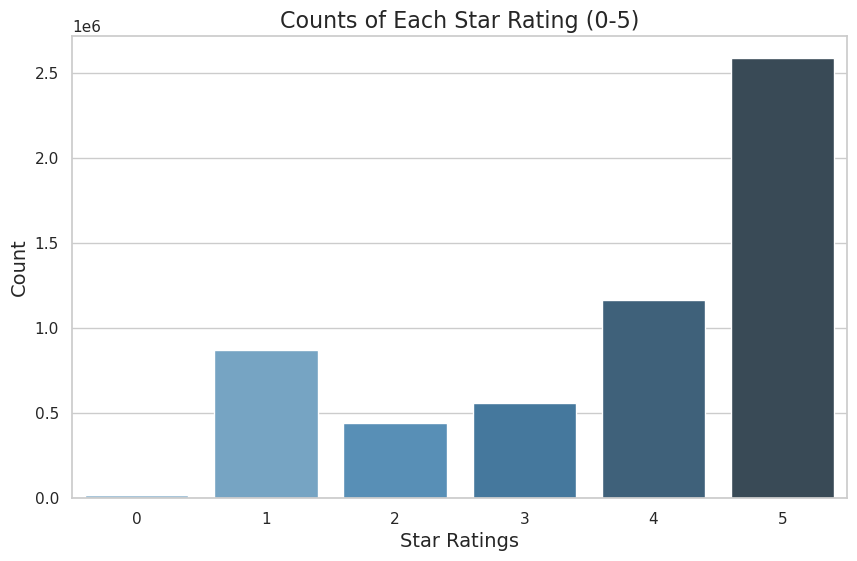

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col

# Calculate the count of each star rating in the Spark DataFrame
rating_counts = df.groupBy("rating").count().orderBy("rating").toPandas()

# Create a bar plot using seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="rating", y="count", data=rating_counts, palette="Blues_d")
plt.xlabel("Star Ratings", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Counts of Each Star Rating (0-5)", fontsize=16)

# Show the plot
plt.show()

In [12]:
plt.savefig("star_rating_counts.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [16]:
display(rating_counts)

,rating,count
0,0,20949
1,1,870167
2,2,445541
3,3,559739
4,4,1165852
5,5,2588575


In [19]:
df.show()

+---+---+------+--------------------+---+----+-----------+----------+-----------+-----+
|_c1|_c3|rating|              review|_c7|year|day_of_week|is_weekend|part_of_day|month|
+---+---+------+--------------------+---+----+-----------+----------+-----------+-----+
|  1|  1|     5|The yogurt flavor...|  2|2016|          6|         0|          0|   11|
|  0|  0|     5|We went with two ...|  1|2016|          5|         0|          0|    8|
|  0|  0|     5|Great day out on ...|  0|2019|          4|         0|          0|    7|
|  0|  0|     5|My friends and I ...|  0|2019|          1|         1|          1|   10|
|  0|  0|     5|Captain allen was...|  0|2019|          1|         1|          0|   10|
|  0|  0|     5|What a great day ...|  0|2020|          6|         0|          2|    5|
|  0|  0|     5|Jonathan was very...|  0|2016|          6|         0|          0|    1|
|  0|  0|     4|Mr. Wong's is exa...|  0|2012|          5|         0|          0|   11|
|  1|  4|     4|I broke down and